Using the main.ipynb for training Transformers was too chaotic for me. This file will be ONLY contain code that is absolutely necessary for finding out how to train the Transformer model.

In [1]:
# if "preprocessing" folder in current folders -> cd back to original folder
%cd /content
import os
if os.path.exists("bsc-thesis"):
  # if bsc-thesis folder already exists; completely remove
  !rm -rf bsc-thesis

branch = "main"
!git clone --branch $branch https://github.com/maviddoerdijk/bsc-thesis.git
%cd bsc-thesis/src
%ls

/content
Cloning into 'bsc-thesis'...
remote: Enumerating objects: 697, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 697 (delta 27), reused 41 (delta 10), pack-reused 620 (from 1)
Receiving objects: 100% (697/697), 25.69 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (381/381), done.
Filtering content: 100% (32/32), 1.75 GiB | 66.90 MiB/s, done.
/content/bsc-thesis/src
backtesting/  data/      main.ipynb  models/         utils/
config/       external/  main.py     preprocessing/


In [2]:
!pip install ta
!pip install prophet
!pip install pykalman
!pip install PyWavelets
!pip install curl-cffi

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=82dab6b8001b341b63d3366e087409e560f0f30f4043a75148224043757ef4a7
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 16.5 MB/s eta 0:00:00


In [13]:
# Module imports
import pandas as pd
import numpy as np
from typing import Optional, Callable, Dict, Any
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn as nn
import itertools

# Custom Imports
from models.statistical_models import create_dataset
from data.data_collection import gather_data
from data.scraper import load_cached_etf_tickers
from preprocessing.cointegration import find_cointegrated_pairs
from preprocessing.data_preprocessing import filter_pairs_data
from preprocessing.technical_indicators import combine_pairs_data
from models.statistical_models import default_normalize
from preprocessing.wavelet_denoising import wav_den
from preprocessing.filters import step_1_filter_remove_nans, step_2_filter_liquidity
from backtesting.trading_strategy import trade, get_gt_yoy_returns_test_dev
from backtesting.utils import calculate_return_uncertainty

## caching imports
from data.data_collection_cache import gather_data_cached, _get_filename, gather_pairs_data_cached
from utils.visualization import plot_return_uncertainty, plot_comparison, plot_train_val_loss


# Any other changes to be made throughout the entire notebook
plt.style.use('seaborn-v0_8')

In [9]:
# NOTE: all the functions used here are explained in much more detail in src/main.ipynb, but this notebook is simply focused on finding how to ge the Transformer model to work as I wish.
startDateStr = '2007-01-01'
endDateStr = '2021-12-31' # documentation said that endDateStr is exclusive for both yahoofinance and the original code, but actually printing the shapes showed otherwise..
instrumentIdsNASDAQandNYSE = load_cached_etf_tickers()
data = gather_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1 = step_1_filter_remove_nans(data['close'], data['open'], data['high'], data['low'], data['vol'], data)
data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, data_original_format_filtered_2 = step_2_filter_liquidity(data_close_filtered_1, data_open_filtered_1, data_high_filtered_1, data_low_filtered_1, data_vol_filtered_1, data_original_format_filtered_1)

pairs_data_filtered = gather_pairs_data_cached(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE, cache_dir='../src/data/cache')
if pairs_data_filtered is None:
  scores, pvalues, pairs = find_cointegrated_pairs(data_original_format_filtered_2)
  pairs_data = {key:value[1]  for (key, value) in pairs.items()}
  pairs_data = sorted(pairs_data.items(), key=lambda x: x[1])
  pairs_data_filtered = filter_pairs_data(pairs_data) # filter based on cointegration in such a way that we can simply pick the highest pair of stocks in the list.
# Extract the most highly cointegrated pairs
ticker_a, ticker_b = pairs_data_filtered[0][0][0], pairs_data_filtered[0][0][1]
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
# Note about pairs_timeseries_df: the timeseries output on which we should train are found in the key "Spread_Close"
# But, also the input features are the following keys: ['S1_rsi', 'S2_rsi', 'S1_mfi', 'S2_mfi', 'S1_adi', 'S2_adi', 'S1_vpt', 'S2_vpt', 'S1_atr', 'S2_atr', 'S1_bb_ma', 'S2_bb_ma', 'S1_adx', 'S2_adx', 'S1_ema', 'S2_ema', 'S1_macd', 'S2_macd', 'S1_dlr', 'S2_dlr']

In [10]:
# hard-coding the tickers
# pick_pairs_data_position = 0
# ticker_a, ticker_b = pairs_data_filtered[pick_pairs_data_position][0][0], pairs_data_filtered[pick_pairs_data_position][0][1]
ticker_a, ticker_b = "SOXX", "SMH"
pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)

In [ ]:
# Set a bunch of variables based on the existing function `execute_kalman_workflow` (Note: Some are changed already)
pairs_timeseries: pd.DataFrame = pairs_timeseries_df
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 20
batch_size: int = 64
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = False

In [28]:


def execute_transformer_workflow(
  pairs_timeseries: pd.DataFrame,
  target_col: str = "Spread_Close",
  burn_in: int = 30, # we remove the first 30 elements, because the largest window used for technical indicators is
  train_frac: float = 0.90,
  dev_frac: float = 0.05,   # remaining part is test
  look_back: int = 20,
  batch_size: int = 64,
  epochs: int = 400,
  patience: int = 150,
  denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den,
  scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler,
  scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)},
  normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize,
  delta: float = 1e-3,
  obs_cov_reg: float = 2.,
  trans_cov_avg: float = 0.01,
  obs_cov_avg: float = 1.,
  return_datasets: bool = False,
  verbose: bool = False,
  add_technical_indicators: bool = True,
  result_parent_dir: str = "data/results",
  filename_base: str = "data_begindate_enddate_hash.pkl",
  pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
):
  if not target_col in pairs_timeseries.columns:
    raise KeyError(f"pairs_timeseries must contain {target_col}")

  # burn the first 30 elements
  pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

  total_len = len(pairs_timeseries_burned)
  train_size = int(total_len * train_frac)
  dev_size   = int(total_len * dev_frac)
  test_size  = total_len - train_size - dev_size # not used, but for clarity

  train = pairs_timeseries_burned[:train_size]
  dev   = pairs_timeseries_burned[train_size:train_size+dev_size] # aka validation
  test  = pairs_timeseries_burned[train_size+dev_size:]

  train_multivariate = train.copy()
  dev_multivariate   = dev.copy() # only for completeness
  test_multivariate  = test.copy() # only for completeness

  if verbose:
      print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

  if denoise_fn is not None: # denoise using wavelet denoising
      train = pd.DataFrame({col: denoise_fn(train[col]) for col in train.columns}) # TODO: unsure whether dev and test should also be denoised?

  x_scaler = scaler_factory(**scaler_kwargs) # important: the scaler learns parameters, so separate objects must be created for x and y
  y_scaler = scaler_factory(**scaler_kwargs)

  if not add_technical_indicators:
      train = train[[target_col]]
      dev = dev[[target_col]]
      test = test[[target_col]]

  # We want a sliding window in our dataset
  # TODO: defining this function should not be part of workflow, but imported from a custom module
  def create_sliding_dataset(mat: np.ndarray,
                            x_scaler: MinMaxScaler,
                            y_scaler: MinMaxScaler,
                            look_back: int = 20):
      """
      X  -> (samples, look_back, features)
      y  -> (samples, 1)   — the next-step Spread_Close (just 1 day in advance)
      """
      X, y = [], []
      for i in range(len(mat) - look_back):
          X.append(mat[i : i + look_back, :]) # window
          y.append(mat[i + look_back, 0]) # value right after the window
      X, y = np.array(X), np.array(y).reshape(-1, 1)

      # scale per feature (fit on the training set once!)
      X_scaled = x_scaler.fit_transform(
          X.reshape(-1, X.shape[-1])
      ).reshape(X.shape)
      y_scaled = y_scaler.fit_transform(y)

      return X, X_scaled, y, y_scaled

  trainX_raw, trainX_scaled, trainY_raw, trainY_scaled = create_sliding_dataset(
      train.values, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back) # train_X_scaled.shape: (2219, 20, 34) // [(t - look_back), look_back, features]
  devX_raw,   devX_scaled,   devY_raw,   devY_scaled   = create_sliding_dataset(
      dev.values,  x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back)
  testX_raw,  testX_scaled,  testY_raw,  testY_scaled  = create_sliding_dataset(
      test.values, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back)


  # use pytorch Dataset class
  class SlidingWindowDataset(Dataset):
      def __init__(self, X: np.ndarray, y: np.ndarray):
          #  cast to float32 once to avoid repeated conversions
          self.X = torch.tensor(X, dtype=torch.float32)      # (N, L, F)
          self.y = torch.tensor(y, dtype=torch.float32)      # (N, 1)

      def __len__(self):
          return self.X.shape[0]

      def __getitem__(self, idx):
          return self.X[idx], self.y[idx]                    # each X: (L, F)

  train_ds = SlidingWindowDataset(trainX_scaled, trainY_scaled)
  dev_ds   = SlidingWindowDataset(devX_scaled, devY_scaled)
  test_ds  = SlidingWindowDataset(testX_scaled, testY_scaled)

  train_loader = DataLoader(train_ds, batch_size=batch_size,
                            shuffle=True,  drop_last=True,  num_workers=0)
  dev_loader   = DataLoader(dev_ds,   batch_size=batch_size,
                            shuffle=False, drop_last=False, num_workers=0)
  test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                            shuffle=False, drop_last=False, num_workers=0)

  print(next(iter(train_loader))[0].shape)   # torch.Size([64, 20, 34]) //  (batch_size, look_back, features)

  class TimeSeriesTransformerv1(nn.Module):
    """
    This version (v1) uses:
    * learnable positional embeddings (simple, so no RoPE and no sinusoidal)
    * only an encoder (followed by a regression head that transforms from form (seq_len, d_model) into (1), with the output form being the Spread_Close prediction)
    """
    def __init__(
        self,
        n_features: int,
        seq_len: int,
        d_model: int = 128,
        nhead: int = 8,
        num_layers: int = 4,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.seq_len = seq_len

        # token projection (linear layer)
        self.input_proj = nn.Linear(n_features, d_model)

        # learnable positional embedding  (1, seq_len, d_model)
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))

        # encoder (important part)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True, # keeps (batch, seq, dim)
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

        # regression head (mainly helps in getting to the right output format)
        self.head = nn.Sequential(
            nn.Flatten(start_dim=1), # (batch, seq_len*d_model)
            nn.Linear(seq_len * d_model, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 1),
        )

    def forward(self, x): # x: (batch, seq_len, n_features)
        x = self.input_proj(x) + self.pos_emb
        x = self.encoder(x) # (batch, seq_len, d_model)
        return self.head(x) # (batch, 1)

  n_features = trainX_scaled.shape[-1]

  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  model  = TimeSeriesTransformerv1(
              n_features=n_features,
              seq_len=look_back,
              d_model=128,
              nhead=8,
              num_layers=4,
              dropout=0.1).to(DEVICE)

  criterion = nn.MSELoss()
  optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

  EPOCHS = epochs
  PATIENCE = patience

  # implement the early stopping logic manually
  best_val = float("inf")
  epochs_no_improve = 0
  print_per_n = 10

  # save train_loss and val_loss to lists for plotting
  train_losses = []
  val_losses = []

  for epoch in range(1, EPOCHS + 1):
      model.train()
      running_loss = 0.0
      for x_batch, y_batch in train_loader:
          x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
          optimizer.zero_grad()
          preds = model(x_batch).squeeze(-1)
          loss  = criterion(preds, y_batch.squeeze(-1))
          loss.backward()
          optimizer.step()
          running_loss += loss.item() * x_batch.size(0)
      train_loss = running_loss / len(train_loader.dataset) # epoch loss = running loss / N samples
      train_losses.append(train_loss)

      model.eval()
      running_loss_val = 0.0
      with torch.no_grad():
          for x_batch, y_batch in dev_loader:
              x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
              preds  = model(x_batch).squeeze(-1)
              running_loss_val += criterion(preds, y_batch.squeeze(-1)).item() * x_batch.size(0)
      val_loss = running_loss_val / len(dev_loader.dataset) # again, epoch loss = running loss / N samples
      val_losses.append(val_loss)

      # print losses in a pretty way
      if epoch % print_per_n == 0:
        print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")


      # manual early stopping logic
      if val_loss < best_val - 1e-5: # 1e-5 to not actually make it zero
          best_val = val_loss
          epochs_no_improve = 0
          torch.save(model.state_dict(), "best_transformer.pt")
      else:
          epochs_no_improve += 1
          if epochs_no_improve >= PATIENCE:
              print("Early stopping triggered.")
              break

  # Now, let's run the model on the testset
  # made sure we're in eval mode
  model.eval()

  all_preds, all_targets = [], []
  with torch.no_grad(): # note for myself: torch.no_grad() makes sure that individual weights are not stored in memory, because we would only need to know those during learning, not during inference
      for x_test_batch, y_test_batch in test_loader:
        x_test_batch = x_test_batch.to(DEVICE)
        preds = model(x_test_batch) # make predictions using model
        # transform the preds and targets back to numpy, as these need to be inverted with the scaler, which expects numpy not tensors
        preds = preds.cpu().numpy()
        y_test_batch = y_test_batch.cpu().numpy()
        all_preds.append(preds)
        all_targets.append(y_test_batch)

  # Helper: Get preds/targets from dataloader, in scaled space
  def get_preds_targets_scaled(dataloader, model, device):
      all_preds = []
      all_targets = []
      model.eval()
      with torch.no_grad():
          for x_batch, y_batch in dataloader:
              x_batch, y_batch = x_batch.to(device), y_batch.to(device)
              preds = model(x_batch).cpu().numpy()
              targets = y_batch.cpu().numpy()
              all_preds.append(preds)
              all_targets.append(targets)
      all_preds = np.concatenate(all_preds).reshape(-1, 1)
      all_targets = np.concatenate(all_targets).reshape(-1, 1)
      return all_preds, all_targets

  ## GETTING MSE's
  # VAL (DEV)
  val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
  val_mse_before_inverse = np.mean((val_preds_scaled - val_targets_scaled) ** 2)
  # Inverse-transform to original space
  val_preds_orig = y_scaler.inverse_transform(val_preds_scaled)
  val_targets_orig = y_scaler.inverse_transform(val_targets_scaled)
  val_mse_after_inverse = np.mean((val_preds_orig - val_targets_orig) ** 2)

  # TEST
  test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
  test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
  test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
  test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
  test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)

  # maybe too much explanation here, but y_hat and y_true respectively represent the predicted and ground truth values
  y_hat_scaled = np.concatenate(all_preds).reshape(-1, 1)
  y_true_scaled = np.concatenate(all_targets).reshape(-1, 1)

  y_hat = y_scaler.inverse_transform(y_hat_scaled)
  y_true = y_scaler.inverse_transform(y_true_scaled)

  ## Trading
  test_s1_shortened = test_multivariate['S1_close'].iloc[look_back:]
  test_s2_shortened = test_multivariate['S2_close'].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
  test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
  forecast_test_shortened_series = pd.Series(y_hat.squeeze(), index=test_index_shortened)
  gt_test_shortened_series = pd.Series(y_true.squeeze(), index=test_index_shortened)

  output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
  gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

  ## Trading: Mean YoY
  min_position = 2.00
  max_position = 4.00
  min_clearing = 0.30
  max_clearing = 0.70
  position_thresholds = np.linspace(min_position, max_position, num=10)
  clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
  yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)


  ## The variables that should be returned, according to what was returned by the `execute_kalman_workflow` func:
  # give same output as was originally the case
  if add_technical_indicators:
    current_result_dir = filename_base.replace(".pkl", "_transformer")
  else:
    current_result_dir = filename_base.replace(".pkl", "_transformer_without_ta")
  result_dir = os.path.join(result_parent_dir, current_result_dir)
  if not os.path.exists(result_dir):
      os.makedirs(result_dir)

  ### Plotting #####
  # 1. Train val loss
  train_val_loss_filename = plot_train_val_loss(train_losses, val_losses, workflow_type="Transformer", pair_tup_str=pair_tup_str, result_dir=result_dir, verbose=verbose, filename_base=filename_base)

  # 2. yoy returns
  yoy_returns_filename = plot_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, test_index_shortened, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

  # 3. predicted vs actual spread plot
  predicted_vs_actual_spread_filename = plot_comparison(gt_test_shortened_series, forecast_test_shortened_series, test_index_shortened, workflow_type="Kalman Filter", pair_tup_str=pair_tup_str, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

  ### Plotting #####
  plot_filenames = {
      "yoy_returns": yoy_returns_filename,
      "predicted_vs_actual_spread": predicted_vs_actual_spread_filename,
      "train_val_loss": train_val_loss_filename
  }
  output: Dict[str, Any] = dict(
      val_mse=val_mse_after_inverse,
      test_mse=test_mse_after_inverse,
      yoy_mean=yoy_mean,
      yoy_std=yoy_std,
      gt_yoy=gt_yoy,
      result_parent_dir=result_parent_dir,
      plot_filenames=plot_filenames
  )

  results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
Plot filenames: {output['plot_filenames']}
  """
  with open(os.path.join(result_dir, "results.txt"), "w") as f:
      f.write(results_str)
  if verbose:
    print(results_str)

  if return_datasets:
      output.update(
          dict(train=train, dev=dev, test=test,
                datasets=dict(
                    train=(trainX_raw, trainX_scaled, trainY_raw, trainY_scaled),
                    dev  =(devX_raw,   devX_scaled,   devY_raw,   devY_scaled),
                    test =(testX_raw,  testX_scaled,  testY_raw,  testY_scaled)
                ))

      )
  return output

startDateStr6 = '2007-01-01'
endDateStr6 = '2021-12-31'
# test 2020/01-2021/12
startDateStrTest6 = '2020-01-01'
endDateStrTest6 = '2021-12-31'
train_frac, dev_frac = _get_train_dev_frac(startDateStr6, endDateStr6, startDateStrTest6, endDateStrTest6)

output = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac, epochs=400)

# output_without_tas = execute_transformer_workflow(pairs_timeseries_df, verbose=True, add_technical_indicators=False, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE), pair_tup_str=f"({ticker_a},{ticker_b})", epochs=20)

Split sizes — train: 2747, dev: 499, test: 500
torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.002276 | val MSE 0.004643
Saved plot to data/results/data_2007_01_01_2021_12_31_4416cb3b_transformer/data_2007_01_01_2021_12_31_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2007_01_01_2021_12_31_4416cb3b_transformer/data_2007_01_01_2021_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2007_01_01_2021_12_31_4416cb3b_transformer/data_2007_01_01_2021_12_31_4416cb3b_groundtruth_comparison.png

Validation MSE: 74.0855941772461
Test MSE: 29.764892578125
YOY Returns: -79.54%
YOY Std: +- 26.08%
GT Yoy: -0.93%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2007_01_01_2021_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2007_01_01_2021_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2007_01_01_2021_12_31_4416cb3b_train_val_loss.png'}
  
Split sizes — train: 2747, dev: 499, test: 500
torch.Size([

/content/bsc-thesis/src/backtesting/utils.py:53: RuntimeWarning: invalid value encountered in scalar power
  return ((mean_returns[-1] / mean_returns[0])**(365 / len(mean_returns)) - 1), ((std_returns[-1] / mean_returns[0]) * np.sqrt(365 / len(mean_returns)))


Saved plot to data/results/data_2007_01_01_2021_12_31_4416cb3b_transformer/data_2007_01_01_2021_12_31_4416cb3b_train_val_loss.png
Saved plot to data/results/data_2007_01_01_2021_12_31_4416cb3b_transformer/data_2007_01_01_2021_12_31_4416cb3b_plot_thresholds.png
Saved plot to data/results/data_2007_01_01_2021_12_31_4416cb3b_transformer/data_2007_01_01_2021_12_31_4416cb3b_groundtruth_comparison.png

Validation MSE: 75.48048400878906
Test MSE: 39.234310150146484
YOY Returns: nan%
YOY Std: +- 30.19%
GT Yoy: -0.93%
Plot filepath parent dir: data/results
Plot filenames: {'yoy_returns': 'data_2007_01_01_2021_12_31_4416cb3b_plot_thresholds.png', 'predicted_vs_actual_spread': 'data_2007_01_01_2021_12_31_4416cb3b_groundtruth_comparison.png', 'train_val_loss': 'data_2007_01_01_2021_12_31_4416cb3b_train_val_loss.png'}
  
Split sizes — train: 2747, dev: 499, test: 500
torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.002258 | val MSE 0.006321
Epoch 020 | train MSE 0.002086 | val MSE 0.004730
Epoch 03

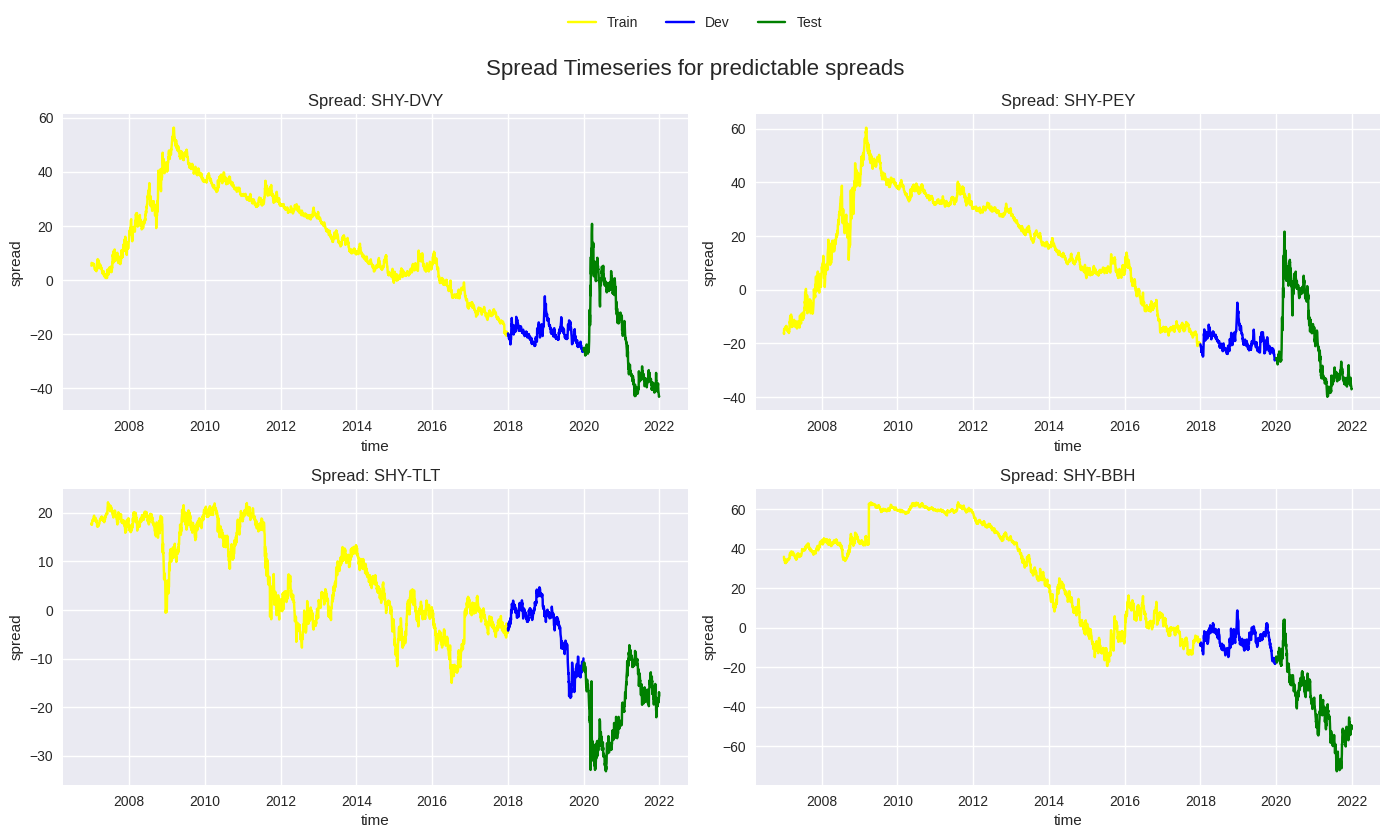

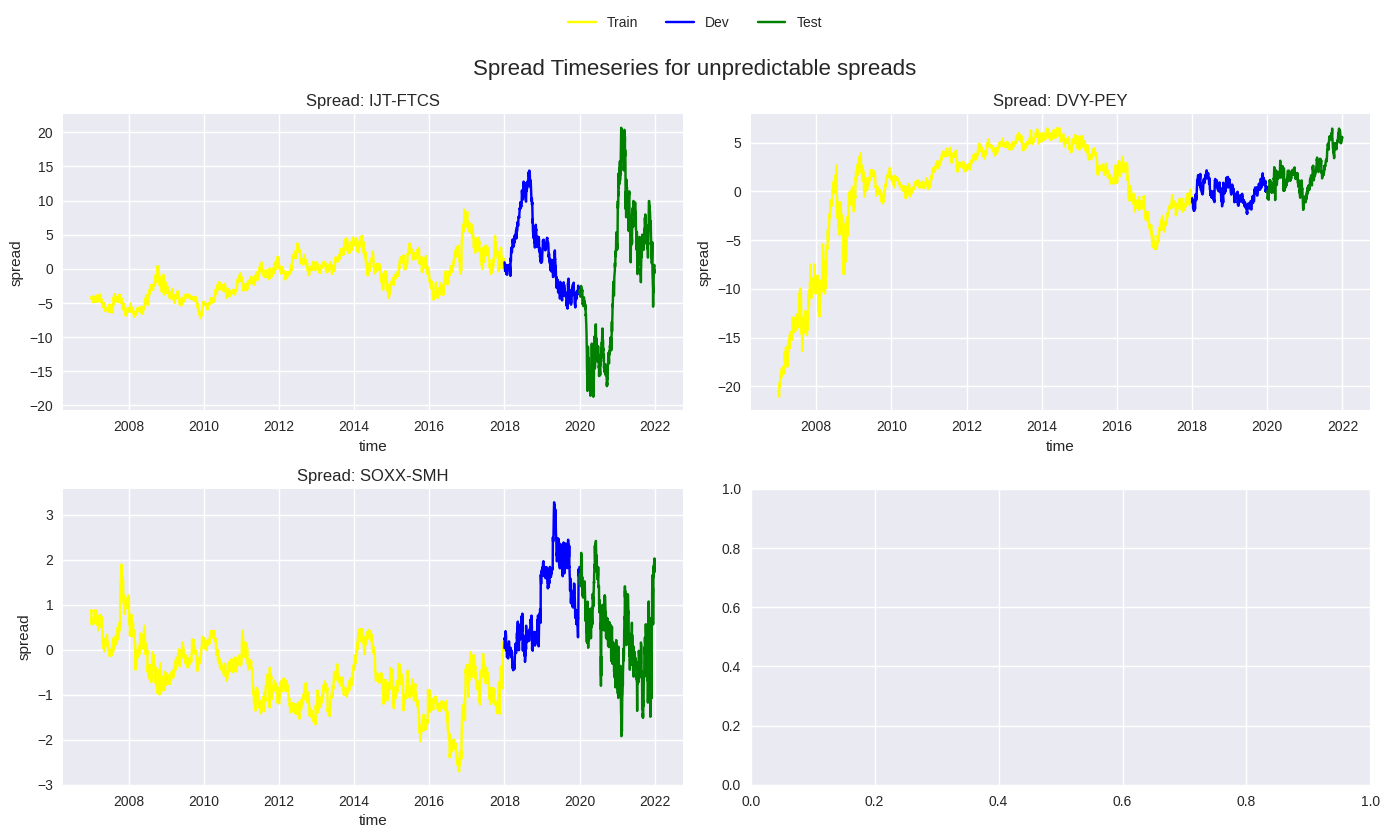

In [40]:
# Let's try and get the results, just using some other pairs.
for i in range(len(pairs_data_filtered)):
  ticker_a, ticker_b = pairs_data_filtered[i][0][0], pairs_data_filtered[i][0][1]
  pairs_timeseries_df = combine_pairs_data(data_close_filtered_2, data_open_filtered_2, data_high_filtered_2, data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b)
  # plot the spread_close timeseries for each one

  # output = execute_transformer_workflow(pairs_timeseries_df, verbose=True, result_parent_dir="data/results", filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE) + f"({ticker_a},{ticker_b})", pair_tup_str=f"({ticker_a},{ticker_b})", train_frac=train_frac, dev_frac=dev_frac, epochs=150)

predictable_iters = [1,2,4,5]
unpreditable_iters = [0, 3, 6]

import matplotlib.lines as mlines

train_line = mlines.Line2D([], [], color='yellow', label='Train')
dev_line = mlines.Line2D([], [], color='blue', label='Dev')
test_line = mlines.Line2D([], [], color='green', label='Test')

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for idx, predictable_iter in enumerate(predictable_iters):
    row, col = divmod(idx, 2)
    ticker_a, ticker_b = pairs_data_filtered[predictable_iter][0][0], pairs_data_filtered[predictable_iter][0][1]
    pairs_timeseries_df = combine_pairs_data(
        data_close_filtered_2, data_open_filtered_2, data_high_filtered_2,
        data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b
    )
    target_timeseries = pairs_timeseries_df['Spread_Close']
    # train_frac, dev_frac
    # test_frac = 1 - train_frac - dev_frac
    train_len = int(len(target_timeseries) * train_frac)
    dev_len = int(len(target_timeseries) * dev_frac)
    test_len = len(target_timeseries) - train_len - dev_len
    ax[row, col].plot(target_timeseries[:train_len], color="yellow")
    ax[row, col].plot(target_timeseries[train_len:train_len + dev_len], color="blue")
    ax[row, col].plot(target_timeseries[train_len + dev_len:], color="green")
    ax[row, col].set_title(f"Spread: {ticker_a}-{ticker_b}")
    ax[row, col].set_xlabel("time")
    ax[row, col].set_ylabel("spread")
fig.suptitle("Spread Timeseries for predictable spreads", fontsize=16)
fig.legend(handles=[train_line, dev_line, test_line], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))


plt.tight_layout()
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(14, 8))

for idx, unpredictable_iter in enumerate(unpreditable_iters):
    row, col = divmod(idx, 2)
    ticker_a, ticker_b = pairs_data_filtered[unpredictable_iter][0][0], pairs_data_filtered[unpredictable_iter][0][1]
    pairs_timeseries_df = combine_pairs_data(
        data_close_filtered_2, data_open_filtered_2, data_high_filtered_2,
        data_low_filtered_2, data_vol_filtered_2, ticker_a, ticker_b
    )
    target_timeseries = pairs_timeseries_df['Spread_Close']
    train_len = int(len(target_timeseries) * train_frac)
    dev_len = int(len(target_timeseries) * dev_frac)
    test_len = len(target_timeseries) - train_len - dev_len
    ax[row, col].plot(target_timeseries[:train_len], color="yellow")
    ax[row, col].plot(target_timeseries[train_len:train_len + dev_len], color="blue")
    ax[row, col].plot(target_timeseries[train_len + dev_len:], color="green")
    ax[row, col].set_title(f"Spread: {ticker_a}-{ticker_b}")
    ax[row, col].set_xlabel("time")
    ax[row, col].set_ylabel("spread")
# give title to whole fig
fig.suptitle("Spread Timeseries for unpredictable spreads", fontsize=16)
fig.legend(handles=[train_line, dev_line, test_line], loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()
plt.show()

In [18]:
output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
output

{'gt_yoy_test': np.float64(-0.009269780597999211),
 'gt_yoy_dev': np.float64(-0.07888546803510088)}

In [21]:
pairs_timeseries = pairs_timeseries_df
verbose=True
result_parent_dir="data/results"
filename_base=_get_filename(startDateStr, endDateStr, instrumentIdsNASDAQandNYSE)
pair_tup_str=f"({ticker_a},{ticker_b})"
epochs=400

pairs_timeseries: pd.DataFrame
target_col: str = "Spread_Close"
burn_in: int = 30 # we remove the first 30 elements, because the largest window used for technical indicators is
train_frac: float = 0.90
dev_frac: float = 0.05   # remaining part is test
look_back: int = 20
batch_size: int = 64
epochs: int = 400
patience: int = 150
denoise_fn: Optional[Callable[[pd.Series], np.ndarray]] = wav_den
scaler_factory: Callable[..., MinMaxScaler] = MinMaxScaler
scaler_kwargs: Optional[Dict[str, Any]] = {"feature_range": (0, 1)}
normalise_fn: Callable[[pd.Series], pd.Series] = default_normalize
delta: float = 1e-3
obs_cov_reg: float = 2.
trans_cov_avg: float = 0.01
obs_cov_avg: float = 1.
return_datasets: bool = False
verbose: bool = False
add_technical_indicators: bool = True
result_parent_dir: str = "data/results"
filename_base: str = "data_begindate_enddate_hash.pkl"
pair_tup_str: str = "(?,?)" # Used for showing which tuple was used in plots, example: "(QQQ, SPY)"
if not target_col in pairs_timeseries.columns:
  raise KeyError(f"pairs_timeseries must contain {target_col}")

# burn the first 30 elements
pairs_timeseries_burned = pairs_timeseries.iloc[burn_in:].copy()

total_len = len(pairs_timeseries_burned)
train_size = int(total_len * train_frac)
dev_size   = int(total_len * dev_frac)
test_size  = total_len - train_size - dev_size # not used, but for clarity

train = pairs_timeseries_burned[:train_size]
dev   = pairs_timeseries_burned[train_size:train_size+dev_size] # aka validation
test  = pairs_timeseries_burned[train_size+dev_size:]

train_multivariate = train.copy()
dev_multivariate   = dev.copy() # only for completeness
test_multivariate  = test.copy() # only for completeness

if verbose:
    print(f"Split sizes — train: {len(train)}, dev: {len(dev)}, test: {len(test)}")

if denoise_fn is not None: # denoise using wavelet denoising
    train = pd.DataFrame({col: denoise_fn(train[col]) for col in train.columns}) # TODO: unsure whether dev and test should also be denoised?

x_scaler = scaler_factory(**scaler_kwargs) # important: the scaler learns parameters, so separate objects must be created for x and y
y_scaler = scaler_factory(**scaler_kwargs)

if not add_technical_indicators:
    train = train[[target_col]]
    dev = dev[[target_col]]
    test = test[[target_col]]

# We want a sliding window in our dataset
# TODO: defining this function should not be part of workflow, but imported from a custom module
def create_sliding_dataset(mat: np.ndarray,
                          x_scaler: MinMaxScaler,
                          y_scaler: MinMaxScaler,
                          look_back: int = 20):
    """
    X  -> (samples, look_back, features)
    y  -> (samples, 1)   — the next-step Spread_Close (just 1 day in advance)
    """
    X, y = [], []
    for i in range(len(mat) - look_back):
        X.append(mat[i : i + look_back, :]) # window
        y.append(mat[i + look_back, 0]) # value right after the window
    X, y = np.array(X), np.array(y).reshape(-1, 1)

    # scale per feature (fit on the training set once!)
    X_scaled = x_scaler.fit_transform(
        X.reshape(-1, X.shape[-1])
    ).reshape(X.shape)
    y_scaled = y_scaler.fit_transform(y)

    return X, X_scaled, y, y_scaled

trainX_raw, trainX_scaled, trainY_raw, trainY_scaled = create_sliding_dataset(
    train.values, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back) # train_X_scaled.shape: (2219, 20, 34) // [(t - look_back), look_back, features]
devX_raw,   devX_scaled,   devY_raw,   devY_scaled   = create_sliding_dataset(
    dev.values,  x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back)
testX_raw,  testX_scaled,  testY_raw,  testY_scaled  = create_sliding_dataset(
    test.values, x_scaler=x_scaler, y_scaler=y_scaler, look_back=look_back)


# use pytorch Dataset class
class SlidingWindowDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        #  cast to float32 once to avoid repeated conversions
        self.X = torch.tensor(X, dtype=torch.float32)      # (N, L, F)
        self.y = torch.tensor(y, dtype=torch.float32)      # (N, 1)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]                    # each X: (L, F)

train_ds = SlidingWindowDataset(trainX_scaled, trainY_scaled)
dev_ds   = SlidingWindowDataset(devX_scaled, devY_scaled)
test_ds  = SlidingWindowDataset(testX_scaled, testY_scaled)

train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True,  drop_last=True,  num_workers=0)
dev_loader   = DataLoader(dev_ds,   batch_size=batch_size,
                          shuffle=False, drop_last=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size,
                          shuffle=False, drop_last=False, num_workers=0)

print(next(iter(train_loader))[0].shape)   # torch.Size([64, 20, 34]) //  (batch_size, look_back, features)

class TimeSeriesTransformerv1(nn.Module):
  """
  This version (v1) uses:
  * learnable positional embeddings (simple, so no RoPE and no sinusoidal)
  * only an encoder (followed by a regression head that transforms from form (seq_len, d_model) into (1), with the output form being the Spread_Close prediction)
  """
  def __init__(
      self,
      n_features: int,
      seq_len: int,
      d_model: int = 128,
      nhead: int = 8,
      num_layers: int = 4,
      dropout: float = 0.1,
  ):
      super().__init__()
      self.seq_len = seq_len

      # token projection (linear layer)
      self.input_proj = nn.Linear(n_features, d_model)

      # learnable positional embedding  (1, seq_len, d_model)
      self.pos_emb = nn.Parameter(torch.randn(1, seq_len, d_model))

      # encoder (important part)
      enc_layer = nn.TransformerEncoderLayer(
          d_model=d_model,
          nhead=nhead,
          dim_feedforward=d_model * 4,
          dropout=dropout,
          batch_first=True, # keeps (batch, seq, dim)
      )
      self.encoder = nn.TransformerEncoder(enc_layer, num_layers)

      # regression head (mainly helps in getting to the right output format)
      self.head = nn.Sequential(
          nn.Flatten(start_dim=1), # (batch, seq_len*d_model)
          nn.Linear(seq_len * d_model, 128),
          nn.ReLU(),
          nn.Dropout(dropout),
          nn.Linear(128, 1),
      )

  def forward(self, x): # x: (batch, seq_len, n_features)
      x = self.input_proj(x) + self.pos_emb
      x = self.encoder(x) # (batch, seq_len, d_model)
      return self.head(x) # (batch, 1)

n_features = trainX_scaled.shape[-1]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model  = TimeSeriesTransformerv1(
            n_features=n_features,
            seq_len=look_back,
            d_model=128,
            nhead=8,
            num_layers=4,
            dropout=0.1).to(DEVICE)

criterion = nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

EPOCHS = epochs
PATIENCE = patience

# implement the early stopping logic manually
best_val = float("inf")
epochs_no_improve = 0
print_per_n = 10

# save train_loss and val_loss to lists for plotting
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x_batch).squeeze(-1)
        loss  = criterion(preds, y_batch.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x_batch.size(0)
    train_loss = running_loss / len(train_loader.dataset) # epoch loss = running loss / N samples
    train_losses.append(train_loss)

    model.eval()
    running_loss_val = 0.0
    with torch.no_grad():
        for x_batch, y_batch in dev_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            preds  = model(x_batch).squeeze(-1)
            running_loss_val += criterion(preds, y_batch.squeeze(-1)).item() * x_batch.size(0)
    val_loss = running_loss_val / len(dev_loader.dataset) # again, epoch loss = running loss / N samples
    val_losses.append(val_loss)

    # print losses in a pretty way
    if epoch % print_per_n == 0:
      print(f"Epoch {epoch:03d} | train MSE {train_loss:.6f} | val MSE {val_loss:.6f}")


    # manual early stopping logic
    if val_loss < best_val - 1e-5: # 1e-5 to not actually make it zero
        best_val = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_transformer.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

# Now, let's run the model on the testset
# made sure we're in eval mode
model.eval()

all_preds, all_targets = [], []
with torch.no_grad(): # note for myself: torch.no_grad() makes sure that individual weights are not stored in memory, because we would only need to know those during learning, not during inference
    for x_test_batch, y_test_batch in test_loader:
      x_test_batch = x_test_batch.to(DEVICE)
      preds = model(x_test_batch) # make predictions using model
      # transform the preds and targets back to numpy, as these need to be inverted with the scaler, which expects numpy not tensors
      preds = preds.cpu().numpy()
      y_test_batch = y_test_batch.cpu().numpy()
      all_preds.append(preds)
      all_targets.append(y_test_batch)

# Helper: Get preds/targets from dataloader, in scaled space
def get_preds_targets_scaled(dataloader, model, device):
    all_preds = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            preds = model(x_batch).cpu().numpy()
            targets = y_batch.cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets)
    all_preds = np.concatenate(all_preds).reshape(-1, 1)
    all_targets = np.concatenate(all_targets).reshape(-1, 1)
    return all_preds, all_targets

# VAL (DEV)
val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
val_mse_before_inverse = np.mean((val_preds_scaled - val_targets_scaled) ** 2)
# Inverse-transform to original space
val_preds_orig = y_scaler.inverse_transform(val_preds_scaled)
val_targets_orig = y_scaler.inverse_transform(val_targets_scaled)
val_mse_after_inverse = np.mean((val_preds_orig - val_targets_orig) ** 2)

# TEST
test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)

if verbose:
    print(f"Validation MSE (before inverse): {val_mse_before_inverse:.6f}")
    print(f"Validation MSE (after  inverse): {val_mse_after_inverse:.6f}")
    print(f"Test MSE (before inverse): {test_mse_before_inverse:.6f}")
    print(f"Test MSE (after  inverse): {test_mse_after_inverse:.6f}")

# maybe too much explanation here, but y_hat and y_true respectively represent the predicted and ground truth values
y_hat_scaled = np.concatenate(all_preds).reshape(-1, 1)
y_true_scaled = np.concatenate(all_targets).reshape(-1, 1)

y_hat = y_scaler.inverse_transform(y_hat_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

test_mse = np.mean((y_hat - y_true) ** 2)
print(f"Test MSE  : {test_mse:.6f}")

## Trading
test_s1_shortened = test_multivariate['S1_close'].iloc[look_back:]
test_s2_shortened = test_multivariate['S2_close'].iloc[look_back:] # use multivariate versions, so we can still access cols like 'S1_close' and 'S2_close'
test_index_shortened = test_multivariate.index[look_back:] # officially doesn't really matter whether to use `test_multivariate` or `test`, but do it like this for consistency
forecast_test_shortened_series = pd.Series(y_hat.squeeze(), index=test_index_shortened)
gt_test_shortened_series = pd.Series(y_true.squeeze(), index=test_index_shortened)

output = get_gt_yoy_returns_test_dev(pairs_timeseries_df, dev_frac, train_frac, look_back=20)
gt_yoy, gt_yoy_for_dev_dataset = output['gt_yoy_test'], output['gt_yoy_dev']

## Trading: Mean YoY
min_position = 2.00
max_position = 4.00
min_clearing = 0.30
max_clearing = 0.70
position_thresholds = np.linspace(min_position, max_position, num=10)
clearing_thresholds = np.linspace(min_clearing, max_clearing, num=10)
yoy_mean, yoy_std = calculate_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds)


## The variables that should be returned, according to what was returned by the `execute_kalman_workflow` func:
# give same output as was originally the case
if add_technical_indicators:
  current_result_dir = filename_base.replace(".pkl", "_transformer")
else:
  current_result_dir = filename_base.replace(".pkl", "_transformer_without_ta")
result_dir = os.path.join(result_parent_dir, current_result_dir)
if not os.path.exists(result_dir):
    os.makedirs(result_dir)

### Plotting #####
# 1. Train val loss
train_val_loss_filename = plot_train_val_loss(train_losses, val_losses, workflow_type="Transformer", pair_tup_str=pair_tup_str, result_dir=result_dir, verbose=verbose, filename_base=filename_base)

# 2. yoy returns
yoy_returns_filename = plot_return_uncertainty(test_s1_shortened, test_s2_shortened, forecast_test_shortened_series, test_index_shortened, look_back, position_thresholds=position_thresholds, clearing_thresholds=clearing_thresholds, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

# 3. predicted vs actual spread plot
predicted_vs_actual_spread_filename = plot_comparison(gt_test_shortened_series, forecast_test_shortened_series, test_index_shortened, workflow_type="Kalman Filter", pair_tup_str=pair_tup_str, verbose=verbose, result_dir=result_dir, filename_base=filename_base)

### Plotting #####
plot_filenames = {
    "yoy_returns": yoy_returns_filename,
    "predicted_vs_actual_spread": predicted_vs_actual_spread_filename,
    "train_val_loss": train_val_loss_filename
}
output: Dict[str, Any] = dict(
    val_mse=val_losses[-1],
    test_mse=test_mse,
    yoy_mean=yoy_mean,
    yoy_std=yoy_std,
    gt_yoy=gt_yoy,
    result_parent_dir=result_parent_dir,
    plot_filenames=plot_filenames
)

results_str = f"""
Validation MSE: {output['val_mse']}
Test MSE: {output['test_mse']}
YOY Returns: {output['yoy_mean'] * 100:.2f}%
YOY Std: +- {output['yoy_std'] * 100:.2f}%
GT Yoy: {output['gt_yoy'] * 100:.2f}%
Plot filepath parent dir: {output['result_parent_dir']}
Plot filenames: {output['plot_filenames']}
"""
with open(os.path.join(result_dir, "results.txt"), "w") as f:
    f.write(results_str)
if verbose:
  print(results_str)

if return_datasets:
    output.update(
        dict(train=train, dev=dev, test=test,
              datasets=dict(
                  train=(trainX_raw, trainX_scaled, trainY_raw, trainY_scaled),
                  dev  =(devX_raw,   devX_scaled,   devY_raw,   devY_scaled),
                  test =(testX_raw,  testX_scaled,  testY_raw,  testY_scaled)
              ))

    )

torch.Size([64, 20, 34])
Epoch 010 | train MSE 0.002092 | val MSE 0.008652
Epoch 020 | train MSE 0.002074 | val MSE 0.007807
Epoch 030 | train MSE 0.001727 | val MSE 0.007952
Epoch 040 | train MSE 0.001712 | val MSE 0.005698
Epoch 050 | train MSE 0.001508 | val MSE 0.005938
Epoch 060 | train MSE 0.001606 | val MSE 0.006761
Epoch 070 | train MSE 0.001298 | val MSE 0.004813
Epoch 080 | train MSE 0.001218 | val MSE 0.004672
Epoch 090 | train MSE 0.001233 | val MSE 0.006009
Epoch 100 | train MSE 0.001124 | val MSE 0.004169
Epoch 110 | train MSE 0.001270 | val MSE 0.006875
Epoch 120 | train MSE 0.000829 | val MSE 0.004249
Epoch 130 | train MSE 0.001098 | val MSE 0.004537
Epoch 140 | train MSE 0.000795 | val MSE 0.003464
Epoch 150 | train MSE 0.000994 | val MSE 0.006711
Epoch 160 | train MSE 0.000764 | val MSE 0.004048
Epoch 170 | train MSE 0.000861 | val MSE 0.004481
Epoch 180 | train MSE 0.000821 | val MSE 0.004501
Epoch 190 | train MSE 0.000793 | val MSE 0.003890
Epoch 200 | train MSE 0.0

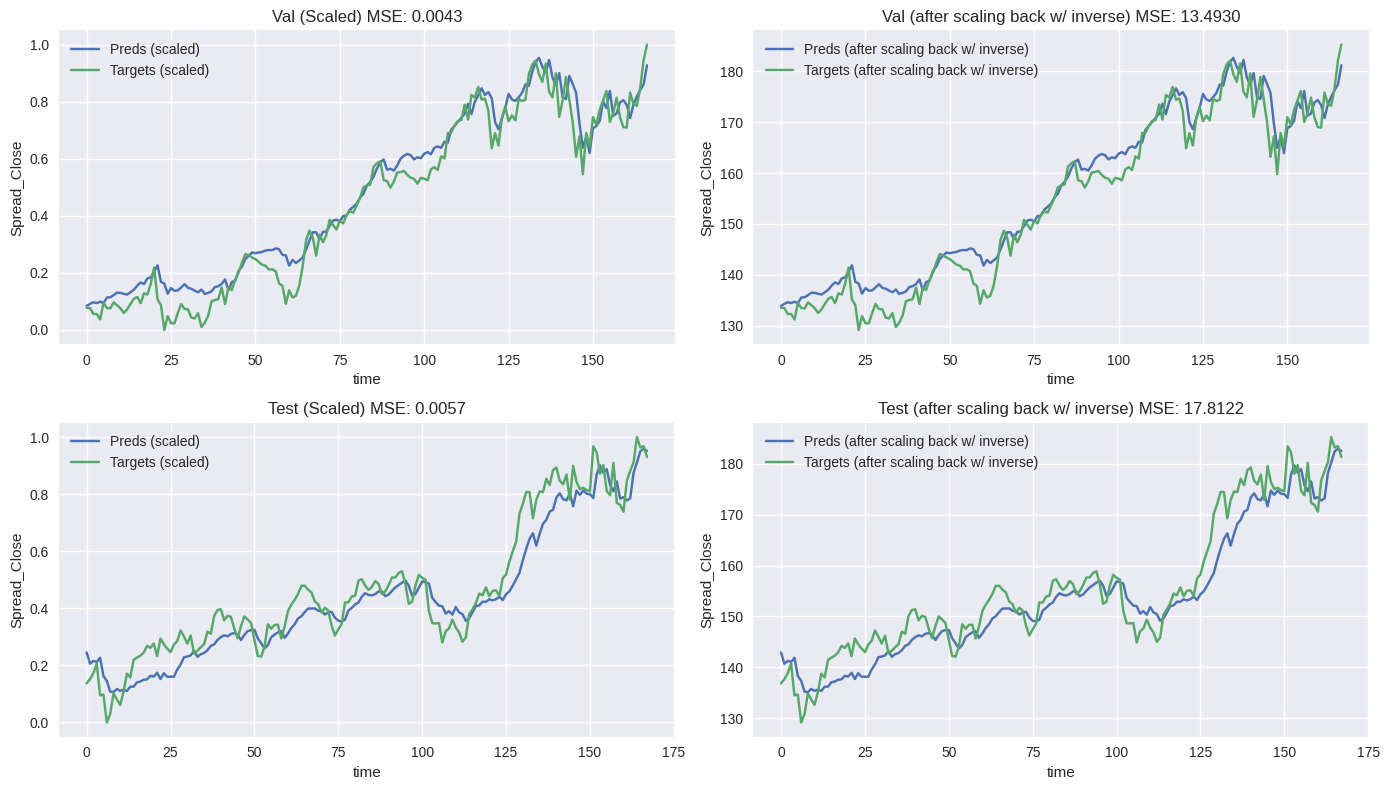

In [27]:
# # VAL (DEV)
# val_preds_scaled, val_targets_scaled = get_preds_targets_scaled(dev_loader, model, DEVICE)
# val_mse_before_inverse = np.mean((val_preds_scaled - val_targets_scaled) ** 2)
# # Inverse-transform to original space
# val_preds_orig = y_scaler.inverse_transform(val_preds_scaled)
# val_targets_orig = y_scaler.inverse_transform(val_targets_scaled)
# val_mse_after_inverse = np.mean((val_preds_orig - val_targets_orig) ** 2)

# # TEST
# test_preds_scaled, test_targets_scaled = get_preds_targets_scaled(test_loader, model, DEVICE)
# test_mse_before_inverse = np.mean((test_preds_scaled - test_targets_scaled) ** 2)
# test_preds_orig = y_scaler.inverse_transform(test_preds_scaled)
# test_targets_orig = y_scaler.inverse_transform(test_targets_scaled)
# test_mse_after_inverse = np.mean((test_preds_orig - test_targets_orig) ** 2)

fig, axs = plt.subplots(2, 2, figsize=(14, 8))

# 1. val scaled
axs[0, 0].plot(val_preds_scaled, label='Preds (scaled)')
axs[0, 0].plot(val_targets_scaled, label='Targets (scaled)')
axs[0, 0].set_xlabel("time")
axs[0, 0].set_ylabel("Spread_Close")
axs[0, 0].set_title(f"Val (Scaled) MSE: {val_mse_before_inverse:.4f}")
axs[0, 0].legend()

# 2. val after inverse
axs[0, 1].plot(val_preds_orig, label='Preds (after scaling back w/ inverse)')
axs[0, 1].plot(val_targets_orig, label='Targets (after scaling back w/ inverse)')
axs[0, 1].set_xlabel("time")
axs[0, 1].set_ylabel("Spread_Close")
axs[0, 1].set_title(f"Val (after scaling back w/ inverse) MSE: {val_mse_after_inverse:.4f}")
axs[0, 1].legend()

# 3. test mse before inverse
axs[1, 0].plot(test_preds_scaled, label='Preds (scaled)')
axs[1, 0].plot(test_targets_scaled, label='Targets (scaled)')
axs[1, 0].set_xlabel("time")
axs[1, 0].set_ylabel("Spread_Close")
axs[1, 0].set_title(f"Test (Scaled) MSE: {test_mse_before_inverse:.4f}")
axs[1, 0].legend()

# 4. test mse after inverse
axs[1, 1].plot(test_preds_orig, label='Preds (after scaling back w/ inverse)')
axs[1, 1].plot(test_targets_orig, label='Targets (after scaling back w/ inverse)')
axs[1, 1].set_xlabel("time")
axs[1, 1].set_ylabel("Spread_Close")
axs[1, 1].set_title(f"Test (after scaling back w/ inverse) MSE: {test_mse_after_inverse:.4f}")
axs[1, 1].legend()

plt.tight_layout()
plt.show()

To get a more reliable plot, we will test out a set of different threshold combinations to be able to plot uncertainty / standard deviation in our returns.



Some examples of outputs for understanding the form of the data better:

`len(trainX_untr)`
```
2238
```

`len(trainX_untr[0])`
```
34
```

Context: The 34 features consist of
* 10 technical indicators for both S1 and S2 (total 20)
* S1_close/open/high/low/volume, same for S2 (total 10)
* Pair spreads: close, open, high, low (total 4)


`trainX_untr[0] `
```
array([ 2.76970068e+01,  4.91006247e+01,  2.89730484e+01,  4.91027293e+01,
        2.89891358e+01,  4.91343834e+01,  2.60513431e+01,  4.87784465e+01,
        5.03546207e+05,  7.43386097e+03,  4.49718063e+01,  5.82671806e+01,
        5.75577766e+01,  8.28358144e+01,  7.59406546e+01,  3.92425336e+02,
        1.05376719e+05, -9.14930577e+03,  1.56861725e+00,  7.63660812e-01,
        2.85638197e+01,  4.83799321e+01,  8.30115861e+00,  2.65305580e+01,
        2.84687992e+01,  4.85740999e+01,  2.27306259e-01,  4.38795633e-02,
       -1.31033890e+00,  1.00654755e-01, -6.89227038e+00, -5.61453974e+00,
       -5.72867758e+00, -8.18838280e+00])
```

`len(trainY_untr)`
```
2238
```


`len(trainY_untr)[0]`
```
1
```

`trainY_untr[0]`
```
array([27.81830352])
```

`trainY_untr[:20]`
```
[array([27.81830352]),
 array([27.42025825]),
 array([25.9191175]),
 array([22.98625305]),
 array([20.5661885]),
 array([21.23151271]),
 array([24.11603916]),
 array([25.605551]),
 array([26.16966699]),
 array([26.46204422]),
 array([25.33065673]),
 array([25.72835342]),
 array([25.91998167]),
 array([25.70591191]),
 array([25.83366537]),
 array([26.33152235]),
 array([26.35160811]),
 array([26.2352556]),
 array([26.03820719]),
 array([25.75521362])]
 ```

`trainX_sliding.shape` (when using look_back=20)

```
 (2219, 20, 34)
```
